# Sorting and Measuring Wave Activity from Short-Time Fourier Transform PSP Magnetic Field Data Algorithmically
We are looking for wave activity that have the following properties:
* coherent (i.e. in phase, non random fluctuations)
* low wave normal angle (i.e. the wave vector is close to parallel to the background magnetic field)
* circularly polarized (can be either left handed or right handed)

The code below conducts the filtering algorithm used to generate the filteredActivity files contained in this dataset. <br>
THIS ASSUMES THE USER HAS ACCESS TO THE WAVE ANALYSIS FILES OF KRISTOFF PAULSON

The following datasets are the result of filtering algorithm applied to a wave analysis of Parker Solar Probe data from Encounters 8 to 16. The wave analysis was conducted by Kristoff Paulson using a Short-Time Fourier Transform (STFT) approach based on polarization techniques derived by Means, 1972 [(DOI 10.1029/JA077i028p055511135)](http://doi.org/10.1029/JA077i028p05551). Included is this jupyter notebook containing the filtering algorithm, demonstrating the results of the filtering, and demonstrating how to best open the files. The dataset for each encounter contains 9 columns that correspond with:

Date in CDF epoch
Left-handed (LH) Integrated Wave Power (nT^2) where integration is over frequency space (0-32 Hz) of filtered activity
Right-handed (RH) Integrated Wave Power (nT^2)
LH median ellipticity where median is over frequency space
RH median ellipticity
LH median coherency
RH median coherency
LH median wave normal angle (deg)
RH median wave normal angle (deg)

In all cases, ellipticity is measured in the Parker Solar Probe spacecraft frame. Ellipticity measures the ellipticity of the polarization ellipse and takes on values between -1 and 1. Values of 1 correspond with RH circular polarization and -1 with LH circular polarization. Coherency takes on values between 0 and 1. It measures how interrelated fluctuations are where 0 represents noise and 1 represents coherent fluctuations. The wave normal angle is the angle between the wave vector, k, and the local mean magnetic field, B. Since there are inherent ambiguities in the direction of the wave vector for single spacecraft measurements, the wave normal angle is calculated such that it takes on angles from 0 to 90 degrees. The filtering algorithm selects activity in which coherency is above 0.8, absolute value of ellipticity is above 0.5, and wave normal angle is below 45 degrees such that coherent, circularly polarized, near parallel propagating wave activity on ion scales is selected.


In [1]:
import sys
print(sys.version)

3.9.1 (v3.9.1:1e5d33e9b9, Dec  7 2020, 12:10:52) 
[Clang 6.0 (clang-600.0.57)]


In [2]:
# tested using python 3.9.1
import os
import glob
import shutil
import pytz
utc = pytz.utc
from datetime import date, timedelta 
from datetime import datetime
import bisect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
import matplotlib.ticker as tck
from scipy import interpolate
from scipy import ndimage

# If this is your first time working with NASA datasets, then it's likely you don't have this library yet! pip install cdflib should work
import cdflib
# import spacepy.plot as splot # only used for making nicely formatted and readable datetime x-axes when plotting, not neccesary

import warnings
warnings.filterwarnings("ignore")

# Helper Functions

In [9]:
def synchronize(epoch_lowCadence,epoch_highCadence,parameter_highCadence,combine=False,int_type='linear',angle=False):
    '''
    Synchronizes two datasets of different cadence using numpy linear interpolation and returns the interpolated array
    for the high cadence (more frequent samples) parameter at the cadence of the low cadence (lower frequency samples) dataset.
    This function is designed for interpolating from high frequency to low frequency, however it can also be used to interpolate
    from low to high. The former is more error prone and should be used more carefully.


    Parameters:
    -------------------
    epoch_lowCadence             :  the epoch of the low cadence dataset which is in an array with datetime dtype
    epoch_highCadence            :  the epoch of the high cadence (i.e. sampled at a higher frequency) dataset which is an 
                                    array of datetime dtype
    parameter_highCadence        :  the data array for the parameter with high cadence associated with the epoch_highCadence. 
                                    Can work with a numpy array with multiple columns of  parameters.
    combine (Default: False)     :  If true and there is more than 1 column in the parameter array, 
                                    then the interpolated parameter arrays are concatenated into a single numpy array with the 
                                    same number of columns.
    int_type (Default: 'linear') :  The type of interpolation used based on the types used in scipy.interpolation.interp1d().
    angle (Default: False)       :  If True then the parameter array is treated as an angle that is periodic on the range [0,360]
                                    and is first unwrapped before interpolation. Ensure any angle parameter array is shifted so that it
                                    is in degrees and lies within [0,360].

    Returns:
    -------------------
    parameters_interpolation  :  a list containing the interpolated arrays for each parameter (i.e. column of parameter_highCadence) given. Each
                                 entry has a length equal to the size of epoch_lowCadence
    
        If combine is true then the list is concatenated along columns into one large array with row # equal to the size of epoch_lowCadence
        and column # equal to the column # of parameter_highCadence
    
    
    '''

    # Create array of seconds elapsed since the first datetime in each epoch.
    
    try: #try based on python datetime approach
        epoch_lowCadence_sec = [(i-epoch_lowCadence[0]).total_seconds() for i in epoch_lowCadence] 
    except: #try based on numpy datetime64 approach
        epoch_lowCadence_sec = [(i-epoch_lowCadence[0])/np.timedelta64(1, 's') for i in epoch_lowCadence] # in the event we're using np.datetime64 dtype
    
    try:
        epoch_highCadence_sec = [(i-epoch_lowCadence[0]).total_seconds() for i in epoch_highCadence] 
    except:
        epoch_highCadence_sec = [(i-epoch_lowCadence[0])/np.timedelta64(1,'s') for i in epoch_highCadence] 

    # converts epoch_highCadence datetime array into an array with the seconds elapse since the starting date of epoch_lowCadence.
    # We use the starting date of epoch_lowCadence as reference for both arrays so that the highCadence time array is in reference
    # to the seconds elapsed since the same starting date and are comparable. 
    # If we used a different starting date for each epoch array, this would influence the time difference between events and
    # the interpolation would be not truly be synchronizing the arrays

    # the number of parameters we want to interpolate. We do each interpolation separately (i.e. 1D interp)
    try: 
        parameter_num = parameter_highCadence.shape[1] # extracts the number of columns for our parameter array indicating number of parameters
    except:
        parameter_num = len(parameter_highCadence)
    
    
    if int_type == 'linear': # for linear interp use np.interp function
        
        if not angle: 
            
            if parameter_num == 1: # single parameter array
                parameters_interpolation = np.interp(epoch_lowCadence_sec,epoch_highCadence_sec, parameter_highCadence)
                combine = False # combine = True has not effect if parameter_num is 1
                
            else: #multiple parameter array
                parameters_interpolation = [] # our output list containing the interpolated arrays for each parameter given
                for i in range(0,parameter_num):
                    parameters_interpolation.append(np.interp(epoch_lowCadence_sec,epoch_highCadence_sec, parameter_highCadence[:,i]))
        else: #interp for an angle parameter array
            
            if parameter_num == 1: #single parameter array

                #unwrap the angle in degrees parameter
                complement360 = np.rad2deg(np.unwrap(np.deg2rad(parameter_highCadence))) # assumes input is in degrees
                
                parameters_interpolation = np.interp(epoch_lowCadence_sec,epoch_highCadence_sec, complement360)
                parameters_interpolation = parameters_interpolation%360 #use mod to wrap angle parameter again
                
                combine = False
            else: #multiple parameter array
                parameters_interpolation = [] # our output list containing the interpolated arrays for each parameter given
                for i in range(0,parameter_num):

                    #unwrap the angle in degrees parameter
                    complement360 = np.rad2deg(np.unwrap(np.deg2rad(parameter_highCadence))) # assumes input is in degrees
                
                    parameter_interpolation = np.interp(epoch_lowCadence_sec,epoch_highCadence_sec, complement360)
                    parameter_interpolation = parameters_interpolation%360 #use mod to wrap angle parameter again
                
                    
                    parameters_interpolation.append(parameter_interpolation)
    else: # for interpolation types that are not linear, scipy.interpolate.interp1d() function is used
        if parameter_num == 1:
            f = interpolate.interp1d(epoch_highCadence_sec, parameter_highCadence,kind=int_type)
            parameters_interpolation = f(epoch_lowCadence_sec)
            combine = False
        else:
            parameters_interpolation = [] # our output list containing the interpolated arrays for each parameter given
            for i in range(0,parameter_num):
                f = interpolate.interp1d(epoch_highCadence_sec, parameter_highCadence[:,i],kind=int_type)
                parameters_interpolation.append(f(epoch_lowCadence_sec))
    
    
    if combine == True:
        # first check the shapes of the arrays are the same and make sure each entry is a column vector
        for i in range(0,parameter_num):
            try:
                parameters_interpolation[i].shape[1]
            except:
                parameters_interpolation[i] = np.array(parameters_interpolation[i],ndmin=2)
                
            if parameters_interpolation[i].shape[1] > parameters_interpolation[i].shape[0]:
                parameters_interpolation[i] = np.transpose(parameters_interpolation[i])
        
        # combine column vectors
        parameters_interpolation  = np.concatenate(tuple(parameters_interpolation),axis=1)  

    return parameters_interpolation


def tt2000_toDatetime64(epoch_ns):
    '''
    Converts an array of times in CDF_tt2000 datatype to np.datetime64 dtype.
    Inputs: list or array of dates in CDF_tt2000 dtype
    Output: numpy array of dates in datetime64 dtype
    '''

    
    datetime_array = cdflib.cdfepoch.breakdown_tt2000(epoch_ns)
    epoch = []
    for i in range(0,datetime_array.shape[0]):
        time_components = datetime_array[i,:] #extracting the time components (year, month, day, hour, minute, second, millisecond, microsecond, nanosecond).

        # Creating a string representation of the time
        time_string = f"{time_components[0]:04d}-{time_components[1]:02d}-{time_components[2]:02d}T{time_components[3]:02d}:{time_components[4]:02d}:{time_components[5]:02d}.{time_components[6]:03d}{time_components[7]:03d}{time_components[8]:03d}Z"
        # converts to the format YYYY-MM-DDTHH:mm:ss.ssssssZ where T indicates the delimiter between date and time and Z indicates Zulu Time (i.e. UTC)

        # Converting the time string to a numpy datetime64 object
        epoch.append(np.datetime64(time_string))

    return np.array(epoch)

def tz_check(date):
    '''
    Sets the timezone to UTC of a date if timezone isn't set
    '''
    
    utc=pytz.UTC
    if not (date.tzinfo is not None and date.tzinfo.utcoffset(date) is not None):
        date = utc.localize(date)
        return date
    else:
        return date 

def datetime_to_tt2000(epoch):
    '''
    Converts python datetime (with precision up to microseconds) to CDF_tt2000 datatype
    Inputs: list or array of dates in datetime
    Output: numpy array of dates in tt2000 dtype
    '''
    epoch_str = [list(map(int, (date.strftime('%Y,%m,%d,%H,%M,%S,%f')[:-3]+','+date.strftime('%Y,%m,%d,%H,%M,%S,%f')[-3:]).split(','))) for date in epoch]
    return cdflib.cdfepoch.compute_tt2000(epoch_str)
    # return compute_tt2000_array(epoch_str)
def datetime_to_cdfepoch(epoch):
    '''
    Converts datetime (with precision up to microseconds) to CDF_epoch dtype
    Inputs: list or array of dates in datetime
    Output: numpy array of dates in CDF epoch dtype
    '''
    epoch_str = [list(map(int, (date.strftime('%Y,%m,%d,%H,%M,%S,%f')[:-3]+','+date.strftime('%Y,%m,%d,%H,%M,%S,%f')[-3:]).split(','))) for date in epoch]
    
    return cdflib.cdfepoch.compute_epoch(epoch_str)

def cdfepoch_to_datetime(epoch):
    '''
    Converts CDF_epoch dtype to datetime (with precision up to milliseconds)
    Inputs: list or array of dates in cdf_epoch dtype
    Output: list of dates in datetime dtype
    '''
    date_list = cdflib.cdfepoch.breakdown_epoch(epoch)      
    # #adjusts the milliseconds element of the date array to contain 6 digits that include milli and microseconds
    # # datetime will ignore additional elements so we don't need to change the original microseconds element.
    return [datetime(*date) for date in date_list]


In [4]:
def import_singleWaveAnalysis(filedate,parameter_list,version='1.2',datetime_convert=False,fileDirectory='./',verbose=False):
    '''
    Reads in all the Kristoff's Wave Analysis cdf files of the form: remoteDirectory/PSP_WaveAnalysis_{day.year}-{day.strftime("%m")}-{day.strftime("%d")}_{day.strftime("%H%M")}_v{version}.cdf
    between the given start and end dates (including the start/end dates) without using pycdf 
    
    
    Parameters:
    --------------------
    fileDirectory: URL or filepath to the directory containing the files
    filedate: date in datetime. Requires month, day, year, and hour. The files come in four different starting hours: 0000, 0600, 1200, and 1800. 
                The code will round to the nearest 6th hour if a different hour is given.
    parameter_list: a list containing the string names of the variables of interest that you want to extract
        Ex: ['np_moment','vp_moment'] if you want to extract the proton number density and velocity moments from the cdf
    version: the version of wave analysis files as a string
    verbose: (default false) when True it prints out more contextual information as function runs
    
    Returns:
    --------------------
    file_cdf: a list containing the cdf of each file in cdflib format.
    parameters_cdf: the numpy data array associated with each parameter in parameter list. 
    parameters_epoch: the epoch dependency associated with each parameter in the parameter list.
    '''
    utc=pytz.UTC
    epoch_localize=np.vectorize(utc.localize) #localizes an array of datetimes to UTC

    #make start and end dates aware
    filedate = tz_check(filedate)

    # if frequency is a parameter, move it to the end of the list. This is helpful for plotting as frequency is a dependency
    if 'Frequencies' in parameter_list:
        parameter_list.remove('Frequencies')
        parameter_list.append('Frequencies')

    # find the closest 6 hour interval (i.e. 00,06,12,18) that is before the given date. 
    closest_6hr = int(np.floor(filedate.hour/6)*6)%24
    start_6hr = datetime(filedate.year,filedate.month,filedate.day,closest_6hr)
    
    # By using "fstrings" we can easily substitute variables into the filename
    remoteFilename = f'PSP_WaveAnalysis_{start_6hr.year}-{start_6hr.strftime("%m")}-{start_6hr.strftime("%d")}_{start_6hr.strftime("%H%M")}_v{version}.cdf'
    
    if verbose:
        print(remoteFilename)

    file = fileDirectory+remoteFilename
    if os.path.isfile(file):
        if verbose:
            print ("File exists already")
    else:
        raise Exception(f"\nFile {file} not found locally")
        
    cdflib_cdf = cdflib.CDF(file) # we use this to actually extract the data

    
    
    files_cdflib = []
    parameters_epoch = []
    parameters_array = []
    
    file_cdflib = cdflib_cdf
    
    for parameter in parameter_list:
        
        parameter_array = cdflib_cdf.varget(parameter)
        try:
            parameter_array  = np.where(parameter_array==cdflib_cdf.attget('FILLVAL',parameter).Data[0], np.nan, parameter_array) # replace fill values with nan
        except:
            print(f'no FILLVAL attribute found for {parameter}')
        parameters_array.append(parameter_array)
        
        # some parameters don't have epochs
        try:
            parameter_epoch = cdflib_cdf.varget(cdflib_cdf.attget('DEPEND_0',parameter).Data) # extract the associated epoch from CDF file
            parameter_epoch = tt2000_toDatetime64(parameter_epoch) # convert tt2000 time into a numpy datetime64 dtype
            # note that you should use timedelta64 when determining time differences with this datatype.
            
            if datetime_convert: # converts epoch data into a standard datetime array
                series = pd.Series(parameter_epoch) # Convert pandas Series to standard datetime array
                parameter_epoch = pd.to_datetime(series).dt.to_pydatetime()
            parameter_epoch = epoch_localize(parameter_epoch)
        except:
            if verbose: # message if extraction of epoch array or its conversion to datetime raises an error
                print(parameter+' does not have an associated epoch') 
            parameter_epoch = None # if a parameter does not have an epoch dependency, we return none for epoch
     
        parameters_epoch.append(parameter_epoch)
        
    return file_cdflib,parameters_array,parameters_epoch


def import_waveAnalysis(start_date,end_date,parameter_list,version='1.2',datetime_convert=False,fileDirectory='./'):
    '''
    Reads in Kristoff's Wave Analysis cdf files of the form: remoteDirectory/PSP_WaveAnalysis_{day.year}-{day.strftime("%m")}-{day.strftime("%d")}_{day.strftime("%H%M")}_v{version}.cdf
    between the given start and end dates (including the start/end dates) without using pycdf 
    V.V refers to version number
    
    
    Parameters:
    --------------------
    remoteDirectory: URL to the directory containing the files
    remoteFileBase: The base naming scheme of the file name before the date
    remoteFilenameFooter: The footer naming scheme of the file name. Typically this is the version given in the form vXX
        where XX indicates the version number. For instance, vesion 2 would be v02.
    start_date: input the start date for data as a datetime object
    end_date: input the end date for data as a datetime object
    parameter_list: a list containing the string names of the variables of interest that you want to extract
        Ex: ['np_moment','vp_moment'] if you want to extract the proton number density and velocity moments from the cdf
    
    Returns:
    --------------------
    files_cdf: a list containing the cdf of each file in cdflib format.
    parameters_cdf: a list containing the numpy data array associated with each parameter in parameter list. 
        To access the cdf for the parameter at index 1 in parameter list use parameters_array[1]
    parameters_epoch: the list containing the epoch dependency associated with each parameter in the parameter list.
    '''

    utc=pytz.UTC
    epoch_localize=np.vectorize(utc.localize) #localizes an array of datetimes to UTC

    #make start and end dates aware
    start_date = tz_check(start_date)
    end_date = tz_check(end_date)

    # if frequency is a parameter, move it to the end of the list. This is helpful for plotting as frequency is a dependency
    if 'Frequencies' in parameter_list:
        parameter_list.remove('Frequencies')
        parameter_list.append('Frequencies')
    else: # if it isn't, append to list
        parameter_list.append('Frequencies')

    # find the smallest 6 hour (i.e. dates with 00,06,12,or 18 as hours) date and largest 6 hour date that bound the start and end dates
    closest_6hr = int(np.floor(start_date.hour/6)*6)%24
    last_6hr = int(np.floor((end_date.hour)/6)*6)%24
    start_6hr = datetime(start_date.year,start_date.month,start_date.day,closest_6hr)
    end_6hr = datetime(end_date.year,end_date.month,end_date.day,last_6hr)
    delta = end_6hr-start_6hr    

    # obtains all the dates between the first 6 hour date and last 6 hour date that contains the start/end dates.
    # by 6 hour date I mean a date of the form YYYYMMDD_HHMM where HHMM is either 0000, 06000, 1200, or 1800
    dates = [start_6hr + timedelta(hours=6*i) for i in range(int((delta.total_seconds())/3600/6)+1)]

    print(dates)
    
    firstTime = True
    for day in dates:
        # By using "fstrings" we can easily substitute variables into the filename
        remoteFilename = f'PSP_WaveAnalysis_{day.year}-{day.strftime("%m")}-{day.strftime("%d")}_{day.strftime("%H%M")}_v{version}.cdf'
        
        print(remoteFilename)

        file = fileDirectory+remoteFilename
        if os.path.isfile(file):
            print ("File exists already")
        else:
            raise Exception(f"\nFile {file} not found locally")
            
        cdflib_cdf = cdflib.CDF(file) # we use this to actually extract the data

        
        if firstTime==True:
            files_cdflib = []
            parameters_epoch = []
            parameters_array = []
            
            files_cdflib.append(cdflib_cdf)
            
            for parameter in parameter_list:
                
                parameter_array = cdflib_cdf.varget(parameter)
                try:
                    parameter_array  = np.where(parameter_array==cdflib_cdf.attget('FILLVAL',parameter).Data[0], np.nan, parameter_array) # replace fill values with nan
                except:
                    print(f'no FILLVAL attribute found for {parameter}')
                parameters_array.append(parameter_array)
                
                # some parameters don't have epochs
                try:
                    parameter_epoch = cdflib_cdf.varget(cdflib_cdf.attget('DEPEND_0',parameter).Data)
                    parameter_epoch = tt2000_toDatetime64(parameter_epoch) # convert tt2000 time into a numpy datetime64 dtype
                    # note that you should use timedelta64 when determining time differences with this datatype.
                    
                    if datetime_convert:
                        series = pd.Series(parameter_epoch) # Convert pandas Series to standard datetime array
                        parameter_epoch = pd.to_datetime(series).dt.to_pydatetime()
                    parameter_epoch = epoch_localize(parameter_epoch)
                except:
                    print(parameter+' does not have an associated epoch')
                    parameter_epoch = None # if a parameter does not have an epoch dependency, we return none for epoch
             
                parameters_epoch.append(parameter_epoch)
                
                
            firstTime = False
            
        elif firstTime==False:
            
            files_cdflib.append(cdflib_cdf)
            for i in range(0,len(parameter_list)):
                
                parameter_array = cdflib_cdf.varget(parameter_list[i])
                try:
                    parameter_array  = np.where(parameter_array==cdflib_cdf.attget('FILLVAL',parameter_list[i]).Data[0], np.nan, parameter_array) # replace fill values with nan
                except:
                    print(f'no FILLVAL attribute found for {parameter_list[i]}')

                try:
                    parameter_epoch = cdflib_cdf.varget(cdflib_cdf.attget('DEPEND_0',parameter_list[i]).Data)
                    parameter_epoch = tt2000_toDatetime64(parameter_epoch) # convert tt2000 time into a numpy datetime64 dtype
                    # note that you should use timedelta64 when determining time differences with this datatype.
                    
                    if datetime_convert:
                        series = pd.Series(parameter_epoch) # Convert pandas Series to standard datetime array
                        parameter_epoch = pd.to_datetime(series).dt.to_pydatetime()
                    
                    parameters_epoch[i]  = np.concatenate( (parameters_epoch[i] ,  epoch_localize(parameter_epoch)) ,  axis=0)
                except:
                    print(parameter_list[i]+' does not have an associated epoch')
                    parameter_epoch = None # if a parameter does not have an epoch dependency, we return none for epoch
                    parameters_epoch[i]  = None
                
                parameters_array[i]  = np.concatenate( (parameters_array[i] ,  parameter_array) ,  axis=0)
                
    # save the data only in the start and end date range
    for i in range(0,len(parameter_list)):
        try:
            startIndex = bisect.bisect_left(parameters_epoch[i], start_date)
            stopIndex  = bisect.bisect_left(parameters_epoch[i], end_date)
            parameters_array[i] = parameters_array[i][startIndex:stopIndex] #extracts the relevant data
            parameters_epoch[i] = parameters_epoch[i][startIndex:stopIndex]
            print(f'{parameter_list[i]} adjusted')
        except:
            pass
        
    return files_cdflib,parameters_array,parameters_epoch

# Plotting Functions

In [5]:
def plot_waveActivity(start,end,parameters,data,epoch,frequencyAxis,
                      parameter_limits,parameter_log,parameter_cmap,parameter_units,
                        restrict_ylim=False,log_freq=False,
                     save=False,pkl=False,show=True,title='PSP B-field Wave Parameters',output_fileBase='waveParameters',
                     verbose=False):
    '''
    Produces a stack plot of wave parameter data as a 2D colormap as a function of time and frequency.

    Inputs:
    ----------
    start : start date in datetime for plot time axis.
    end : end date in datetime of plot time axis.
    parameters : a list of strings indicating the name of the wave parameters in the same order as 'data'.
    data : a list of 2D wave parameter arrays in same order as 'parameters'. Each array should be of the same size
    epoch : an array of datetimes associated with all the 2D wave parameter arrays in 'data'. 
            Length should be equal to the column number of each array.
    frequencyAxis : an array of frequencies (in Hz) associated with all the 2D wave parameter arrays in 'data'. 
                    Length should be equal to the row number of each array.
    parameter_log : list of booleans the same size as 'parameters' indicating whether the parameter colormap is plotted 
                    with log10 scale (True) or linear scale (False).
    parameter_cmap : list of strings the same size as 'parameters' indicating the matplotlib colormap to use for each
                     wave parameter.
    parameter_units : list of strings the same size as 'parameters' indicating the relevant units used for each
                     wave parameter.
    restrict_ylim (Default: False) : If True, restricts the frequency axis to be within 0 to 32 Hz if it isn't already.
    log_freq (Default: False): If True, plots frequency axis with a log10 scale.
    save (Default: False): If True, saves plot as png file with 300 dpi with filename 
                           f"{output_fileBase}_{start.strftime('%Y-%m-%d_%H%M')}__{end.strftime('%Y-%m-%d_%H%M')}.png"
    pkl (Default: False): If True, pickles plot and saves the python figure. This allows for the storage of the figure
                          that can be reloaded and edited without the long process of reading in the waveAnalysis files.
                          Filename of the form:
                           f"{output_fileBase}_{start.strftime('%Y-%m-%d_%H%M')}__{end.strftime('%Y-%m-%d_%H%M')}.fig.pkl"
    show (Default: True): If True, then plot is displayed to output.
    title (Default: 'PSP B-field Wave Parameters'): the title of the plot
    output_fileBase (Default: 'waveParameters'): the base filename used for saving the figure as a png or pickle.
    verbose (Default: False): If true, prints additional contextual information during the running of the code.
    

    Outputs:
    ---------
    fig : figure of the plot
    ax : axis of the plot
    These are returned so that the plot can be edited further after plotting if so desired.
    
    '''
    
    
    utc=pytz.UTC
    epoch_localize=np.vectorize(utc.localize) #localizes an array of datetimes to UTC

    #make sure start/end dates are localized
    start = tz_check(start) 
    end = tz_check(end)
    
    if verbose:
        print('start of time period:',start.strftime('%m/%d/%y %H:%M'))
        print('end of time period:',end.strftime('%m/%d/%y %H:%M'))


    startIndex = np.searchsorted(epoch, start)
    stopIndex  = np.searchsorted(epoch, end)

    # make x_lims based on the start and end dates
    x_lims = mdates.date2num([epoch[startIndex],epoch[stopIndex-1]])
    # print(epoch[0],epoch[startIndex],epoch[stopIndex-1])

    n = len(parameters) #number of plots for the stack
    

    fig, ax = plt.subplots(n,1,sharex=True,constrained_layout=True)
    fig.set_size_inches(14,2*n)

    
    X, Y = np.meshgrid(epoch[startIndex:stopIndex], frequencyAxis) # meshgrid of time (X) and frequency (Y)
    fAxis_min = frequencyAxis.min()
    fAxis_max = frequencyAxis.max()
    
    for plot_index in range(0,n):
        
        if parameter_log[plot_index]: # plot parameter with log scale

            if parameter_limits[plot_index] == None: #if None on parameter limits, then we don't set colorbar limits

                pcm = ax[plot_index].pcolormesh(X, Y, np.transpose(data[plot_index]), cmap=parameter_cmap[plot_index],
                                                norm=colors.LogNorm(),shading='nearest')  
            elif (parameter_limits[plot_index][0] != 0): #LogNorm struggles when we set vmin to 0
               
                pcm = ax[plot_index].pcolormesh(X, Y, np.transpose(data[plot_index]), cmap=parameter_cmap[plot_index],
                                                norm=colors.LogNorm(vmin = parameter_limits[plot_index][0],vmax  =  parameter_limits[plot_index][1]),shading='nearest')  
            else: # if given vmin is 0, let LogNorm function determine a minimum 
                
                pcm = ax[plot_index].pcolormesh(X, Y, np.transpose(data[plot_index]), cmap=parameter_cmap[plot_index],
                                                norm=colors.LogNorm(vmax  =  parameter_limits[plot_index][1]),shading='nearest')
        else: # plot parameter without log scale
           
            pcm = ax[plot_index].pcolormesh(X, Y, np.transpose(data[plot_index]), cmap=parameter_cmap[plot_index],
                                            vmin  =  parameter_limits[plot_index][0], vmax  =  parameter_limits[plot_index][1],
                                            shading='nearest')  
        
        if log_freq: # apply log scale to frequency if log_freq is True
            ax[plot_index].set_yscale('log')
            ax[plot_index].set_ylim([0.5,32])

        # format x-axis for date format
        ax[plot_index].xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax[plot_index].xaxis.set_major_formatter(date_format)

        # requires import spacepy.plot, which can be a pain to download correctly
        # splot.applySmartTimeTicks(ax[plot_index], epoch[startIndex:stopIndex], dolimit=False, dolabel=False) # makes time ticks spaced in a nice readable way
        
        ax[plot_index].grid(False) # turns off grid
        ax[plot_index].yaxis.set_minor_locator(tck.AutoMinorLocator()) #turns on minor ticks

        # create colorbar and label it
        cbar = fig.colorbar(pcm)
        cbar.ax.set_ylabel(f'{parameters[plot_index]}\n${{{parameter_units[plot_index]}}}$',rotation=270,labelpad=35)
        plt.subplots_adjust(right=0.85) # give room for cbar

        if restrict_ylim:
            ax[plot_index].set_ylim([0,32]) #make sure we limit yaxis to 0 to 32 Hz, some data may be from 0 to 150 Hz
            
        if plot_index == n-1: # for the last plot in stack, make an x-axis label
            ax[plot_index].set_xlabel(f'{start.strftime("%Y-%m-%d %H:%M")} -- {end.strftime("%Y-%m-%d %H:%M")} (UT)')            

        # set title and y-axis for top plot of stack
        if plot_index == 0: 
            ax[plot_index].set_title(f'{title}', fontsize=12)                                      
        if plot_index == 0:
            ax[plot_index].set_ylabel('Frequency (Hz)')
        
        #format minor y ticks
        ax[plot_index].tick_params(axis="y",
                    which="minor",
                    length=8,
                    direction='out')  
        plt.tick_params()
        #format major y ticks
        ax[plot_index].tick_params(axis="y",
                        which="major",
                        length=10,
                        direction='out')
        #format minor x ticks
        ax[plot_index].tick_params(axis="x",
                    which="minor",
                    length=8,
                    direction='out')  
        #format major x ticks
        ax[plot_index].tick_params(axis="x",
                        which="major",
                        length=10, # larger than minor
                        direction='out')

    # fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0.1)
   
                                    
    if pkl: # pickle the figure
        filename = f"{output_fileBase}_{start.strftime('%Y-%m-%d_%H%M')}__{end.strftime('%Y-%m-%d_%H%M')}"
        if log_freq: # add additional naming schemes to indicate log scale frequency axis
            filename = filename + "_logFreq"
        filename = filename + ".fig.pkl"

        pickle.dump([fig,ax], open(filename, 'wb'))
        # use pickle.load(open("waveParameters_{start.strftime('%Y-%m-%d_%H%M')}__{end.strftime('%Y-%m-%d_%H%M')}.fig.pkl",'rb')) to load in figure
    if save:
        filename = f"{output_fileBase}_{start.strftime('%Y-%m-%d_%H%M')}__{end.strftime('%Y-%m-%d_%H%M')}"
        if log_freq: # add additional naming schemes to indicate log scale frequency axis
            filename = filename + "_logFreq"
        filename = filename + ".png"
                                      
        fig.savefig(filename,dpi=300)
    
    if show: # show plot otherwise close plot to prevent it displaying to output
        plt.show()
    else:
        plt.close()                                      
                                      
    return fig, ax

# Algorithm

In [6]:
def filter_activity(wave_parameters,parameter_names,frequencyAxis,coherency_filter=0.8,circPol_filter=0.5,waveNormAngle_filter=45,filter_size=10,trim=1.5,verbose=False):
    '''
    Function that applies a filter to wave parameter data. Must include coherency, ellipticity, and wave_normal in wave parameters.
    The filter is not a strict cut on the given coherency/ellipticity/waveNormAngle filters. It uses a median of surrounding points 
    to compare to the given filter bounds.

    Inputs:
    ---------------
    wave_parameters: a list or array of wave parameter data.
    parameter_names: a list the same size as wave_parameters indicating the name of the corresponding wave parameter.
                     The standard names in the waveAnalysis cdf files that this function expects are coherency_b, 
                     ellipticity_b, and wave_normal_b. In earlier versions only the wave vector direction along the 
                     magnetic field (kz_b) was given and the wave normal angle must be first calculated from it.
    frequencyAxis: an array the same size as the number of rows of each parameter that indicates the frequency values (in Hz)
                   for each row.
    coherency_filter (Default: 0.8): A number between 0 and 1 that sets the lower bound for coherency data.
    circPol_filter (Default: 0.5): A number between 0 and 1 that sets the lower bound for the absolute value of ellipticity 
                                   data. Values near 1 indicate data that is more circularly polarized.
    waveNormAngle_filter (Default: 45): A number in degrees that sets the upper bound for wave normal angle data.
    filter_size (Default: 10): Determines the footprint used for ndimage.median_filter(). Indicates number of surrounding points
                               used for filter.
    trim (Default: 1.5): The amount of data trimmed from bottom and top bounds of the frequency axis given in Hz.
                         Data that lies outside frequencyAxis.max()-trim <= f <= frequencyAxis().min()+trim are filtered out.
    verbose (Default: False): If True, provides additional contextual information while function runs.
    
    Outputs:
    -----------
    df: a pandas dataframe containing arrays of integrated or median values (over frequency space) of filtered data. 
        Columns are labeled. The dataframe loses information but takes up a lot less space.
    wave_parameters: returns the wave_parameters that are now filtered
    '''

    # raise errors if all the necessary wave parameters are not given
    if ('wave_normal_b' not in parameter_names) and ('kz_b' not in parameter_names):
        raise ValueError('Need wave_normal_b parameter to filter out high normal angles')
    if 'coherency_b' not in parameter_names:
        raise ValueError('Need coherency_b parameter to filter out incoherency')
    if 'ellipticity_b' not in parameter_names:
        raise ValueError('Need ellipticity_b parameter to filter out non-circularly polarized data')

    frequencyBinWidth = frequencyAxis[1]-frequencyAxis[0]

    # filter using a median filter on the coherency and wave normal angle bounds given

    # obtain mask of data that fails filters
    try: # first try wave_normal_b
        coherency_waveNorm_condition = (ndimage.median_filter(wave_parameters[parameter_names.index('coherency_b')],size=filter_size)<coherency_filter) | (ndimage.median_filter(wave_parameters[parameter_names.index('wave_normal_b')],size=filter_size)>waveNormAngle_filter)
    except: # if this fails try using kz_b
        coherency_waveNorm_condition = (ndimage.median_filter(wave_parameters[parameter_names.index('coherency_b')],size=filter_size)<coherency_filter) | (ndimage.median_filter(wave_parameters[parameter_names.index('kz_b')],size=filter_size)>waveNormAngle_filter)
    
    if verbose:    
        print(f'Filtering out incoherent high normal angle data that falls below a coherency of {coherency_filter} and above wave normal angle of {waveNormAngle_filter} deg')

    # for data that fails filters, replace with np.nan
    for i in range(0,len(wave_parameters)):
        wave_parameters[i] = np.where(coherency_waveNorm_condition,np.nan,wave_parameters[i])

    

    # ellipticity filtering out linear polarization and sorting into right handed and left handed
    circPol_condition = np.abs(ndimage.median_filter(wave_parameters[parameter_names.index('ellipticity_b')],size=filter_size))>= circPol_filter
    right_hand_condition = ndimage.median_filter(wave_parameters[parameter_names.index('ellipticity_b')],size=filter_size)>= circPol_filter
    left_hand_condition = ndimage.median_filter(wave_parameters[parameter_names.index('ellipticity_b')],size=filter_size)<= -1*circPol_filter

    if verbose:
        print(f'Filtering out linear polarization below ellipticity of {circPol_filter} and sorting into rh and lh circular polarization')

    for i in range(0,len(wave_parameters)):
        wave_parameters[i] = np.where(circPol_condition,wave_parameters[i],np.nan)

    # trim top and bottom frequency bins to remove edge effects. If trim is < 0 then no trim is applied.
    if trim>0:
        if verbose:
            print(f'Trimming top and bottom frequencies by {trim} Hz')
        frequency_Trim = np.repeat(np.array((frequencyAxis < np.ceil(np.max(frequencyAxis))-trim) & (frequencyAxis > np.floor(np.min(frequencyAxis))+trim),dtype=bool,ndmin=2),wave_parameters[0].shape[0],axis=0)
        for i in range(0,len(wave_parameters)):
            wave_parameters[i] = np.where(frequency_Trim,wave_parameters[i],np.nan)

    rh_data=[]; lh_data=[];
    for i in range(0,len(wave_parameters)):
        rh_data.append(np.where(right_hand_condition,wave_parameters[i],np.nan))
        lh_data.append(np.where(left_hand_condition,wave_parameters[i],np.nan))

    # the data has now been filtered to extract high coherency and low wave normal activity, trimmed in the top/bottom frequency bins, 
    # and sorted into rh circ pol and lh circ pol. We now want to sum the wave parameters along the frequency axis and multiply by the frequency bin width
    # this amounts to a midpoint Reimann sum approximation of the integral
    rh_integrated_data = []
    lh_integrated_data = []
    for i in range(0,len(wave_parameters)):
        if parameter_names[i] is 'Wave_Power_b':
            rh_integrated_data.append(np.nansum(rh_data[i],axis=1)*frequencyBinWidth)
            lh_integrated_data.append(np.nansum(lh_data[i],axis=1)*frequencyBinWidth)
        else:
            rh_integrated_data.append(np.nanmedian(rh_data[i],axis=1))
            lh_integrated_data.append(np.nanmedian(lh_data[i],axis=1))

    df = pd.DataFrame(data = [lh_integrated_data[0],rh_integrated_data[0],lh_integrated_data[1],rh_integrated_data[1],lh_integrated_data[2],rh_integrated_data[2],lh_integrated_data[3],rh_integrated_data[3]]).T
    df.columns=['lh integrated wave power (nT^2)','rh integrated wave power(nT^2)','lh med ellipticity','rh med ellipticity','lh med coherency','rh med coherency','lh med wave normal angle','rh med wave normal angle']

    return df,wave_parameters

In [13]:
def extract_activity(start_date,end_date,coherency_filter=0.8,circPol_filter=0.5,waveNormAngle_filter=45,filter_size=10,trim=1.5,
                     version='1.2',fileDirectory='./',outputDirectory='./',plot_show=False,plot_save=False,
                     verbose=False,unix_output=False,skip_existing=True,fileLog=False):
    '''
    Extracts the coherent, circularly polarized, low wave normal angle wave activity and calculates the integrated wave power across frequency space at the cadence of the input WaveAnalysisFiles.
    --------
    Inputs:
    --------
    start_date  :  starting date to look for WaveAnalysis files in datetime (assumes utc timezone)
    
    end_date  :  end date for WaveAnalysis files in datetime (assumes utc timezone). Looks for dates up until the file that includes the end date.
    
    coherency_filter  :  (default 0.8) wave activity below this limit (through a top hat median approach) are removed. Can range from 0 to 1
    
    circPol_filter  :  (default 0.5) |ellipticity| data below this limit (through a top hat median approach) are removed. Can range from 0 to 1
    
    waveNormAngle_filter  :  (default 45) wave normal angle data (in degrees) above this limit are removed. Can range from 0 to 90
    
    filter_size  :  (default 10) the footprint used for the top hat filter. If you want an asymmetric footprint (look at more neighbors in one axis versus the other) input an integer tuple (rows,cols).
    
    trim  :  (default 1.5) masks the data in rows corresponding to frequencies such that f > ceil(max(frequency)) - trim and f < floor(min(frequency) + trim (the values are assumed to be in Hz) to remove edge defects
    
    version  :  (default '1.2') the version of WaveAnalysis files being imported
    
    fileDirectory  :  (default './') the directory where the WaveAnalysis files are stored

    outputDirectory  :  (default './') the directory where the filteredActivity txt file is written
    
    plot_show  :  (default False) outputs 2 plots every 5 files (starting on the first file): one of the extracted activity and one for the original activity
    
    plot_save  :  (default False) saves 2 plots every 5 files (starting on the first file): one of the extracted activity and one for the original activity
    
    verbose  :  (default False) If true, outputs more contextual information
    
    unix_output  :  (default False) If true, output text file uses unix time for the time column. If false, uses cdf epoch (with only millisecond precision).
    
    skip_existing  :  (default True) If true, skips files in which filteredActivity txt file already exists

    fileLog  :  (default False) If true, writes input file range and missing files to a txt file.
    
    ---------
    Outputs: 
    ---------
    Writes the integrated wave power and median wave parameter statistics (coherency/ellipticity/wave norm angle) of wave activity (split into left and right hand circular polarization) to a csv file of the form: 
    fileDirectory+f"filteredActivity_{filedate.strftime('%Y-%m-%d_%H%M')}.txt
    
    '''
    


    
    #make start and end dates timezone aware
    start_date = tz_check(start_date)
    end_date = tz_check(end_date)
    
    closest_6hr = int(np.floor(start_date.hour/6)*6)%24
    last_6hr = int(np.floor((end_date.hour)/6)*6)%24
    start_6hr = datetime(start_date.year,start_date.month,start_date.day,closest_6hr)
    end_6hr = datetime(end_date.year,end_date.month,end_date.day,last_6hr)
    delta = end_6hr-start_6hr    

    # obtains all the dates between the first 6 hour date and last 6 hour date that contains the start/end dates.
    # by 6 hour date I mean a date of the form YYYYMMDD_HHMM where HHMM is either 0000, 06000, 1200, or 1800
    dates = [start_6hr + timedelta(hours=6*i) for i in range(int((delta.total_seconds())/3600/6)+1)]

    
    if len(dates) == 1:
        print(f"Searching for 6 hr file starting on {dates[0].strftime('%Y-%m-%d_%H%M')}")
    else:
        print(f"Searching for 6 hr files from {dates[0].strftime('%Y-%m-%d_%H%M')} to {dates[-1].strftime('%Y-%m-%d_%H%M')}")

    if fileLog:
        f = open(outputDirectory+f"log_{dates[0].strftime('%Y-%m-%d_%H%M')}_to_{dates[-1].strftime('%Y-%m-%d_%H%M')}.txt", "w")
    
    
    if version is '1.2':
        # this version incorrectly calculates the wave_normal angle so we must calculate it from kz_b
        parameters_list = ['Wave_Power_b','ellipticity_b','coherency_b','kz_b','Frequencies']
    else:
        parameters_list = ['Wave_Power_b','ellipticity_b','coherency_b','wave_normal_b','Frequencies']
    i=0
    for date in dates:

        if skip_existing:
            if os.path.isfile(outputDirectory+f"filteredActivity_{date.strftime('%Y-%m-%d_%H%M')}.txt"):
                if fileLog:
                    f.write(f"txt file already exists for {date.strftime('%Y-%m-%d_%H%M')}; skipping\n")
                print(f"txt file already exists for {date.strftime('%Y-%m-%d_%H%M')}; skipping")
                continue
            
            
        
        # check if txt file exists

        
        try: 
            filecdf,wave_data,epochs = import_singleWaveAnalysis(date,parameters_list,version = version,datetime_convert=True,
                                                     fileDirectory=fileDirectory,verbose=verbose)
        except:
            if fileLog:
                f.write(f"Unable to find file for {date.strftime('%Y-%m-%d_%H%M')}, version v{version}\n")
            print(f"Unable to find file for {date.strftime('%Y-%m-%d_%H%M')}, version v{version}")
            continue
        #wave_data[-1] is the frequencyAxis
        if version is '1.2':
            wave_data[-2] = np.arccos(wave_data[-2]) * 180/np.pi 
        
        filter_df,wave_data_filtered = filter_activity(wave_data[:-1],parameters_list[:-1],wave_data[-1],
                                                        coherency_filter=coherency_filter,circPol_filter=circPol_filter,waveNormAngle_filter=waveNormAngle_filter,filter_size=filter_size,trim=trim,
                                                      verbose=verbose)

        
        # every fifth file plot wave_parameters
        if i%5 == 0 and (plot_show or plot_save):
            # below are the parameter limits, log scales, color maps, and units used to make plots in the paper
            parameter_limits = [
                                [2e-3,1e2],
                                [filecdf.attget('VALIDMIN',parameters_list[1]).Data,filecdf.attget('VALIDMAX',parameters_list[1]).Data], 
                                [0,1],
                                [0,90]
                               ] 
            parameter_log = [True,False,False,False]
            parameter_cmap = ['plasma','bwr','binary','binary']
            parameter_units = [filecdf.attget('UNITS',param).Data for param in parameters_list[:-1]]
            parameter_units[0] = '(nT^2/Hz)' # wave power units
            parameter_units[3] = '(deg)'
    
            
            fig,ax = plot_waveActivity(date,date + timedelta(hours=6),parameters_list[:-1],wave_data_filtered,epochs[1],wave_data[-1],
                               parameter_limits,parameter_log,parameter_cmap,parameter_units,
                                       show=plot_show,save=plot_save,
                                       title=f'Filtered Wave Activity: c>{coherency_filter}, |ϵ|>{circPol_filter}, θ<{waveNormAngle_filter} deg',
                                       output_fileBase='filteredParameters',verbose=verbose
                              )
            if plot_show:
                plt.show()
    
            fig,ax = plot_waveActivity(date,date + timedelta(hours=6),parameters_list[:-1],wave_data[:-1],epochs[1],wave_data[-1],
                               parameter_limits,parameter_log,parameter_cmap,parameter_units,
                                       show=plot_show,save=plot_save,
                                       title=f'Original Wave Parameters',
                                       output_fileBase='originalParameters',verbose=verbose
                              )
            if plot_show:
                plt.show()
        i+=1
        
        # assemble the wave activity data into a pandas dataframe and write to text file
        # seconds_elapsed_epoch = np.array([(epochs[1][i]-epochs[1][0]).total_seconds() for i in range(0,len(epochs[1]))],dtype=np.float64) # seconds elapsed since the start date of the file.
        if unix_output:
            unix_time = [date.replace(tzinfo=utc).timestamp() for date in epochs[1]] #Unix time (aka) seconds elapsed since January 1st 1970
            filter_df.insert(0,'unix time (s)',unix_time,False)

        else:
            cdfepoch = datetime_to_cdfepoch(epochs[1])
            filter_df.insert(0,'cdf epoch',cdfepoch,False)
            
        if i%3 == 0:
            print(f"writing {date.strftime('%Y-%m-%d_%H%M')} filtered activity to txt")
        filter_df.to_csv(outputDirectory+f"filteredActivity_{date.strftime('%Y-%m-%d_%H%M')}.txt", header=None, index=None) #should I add something to indicate filter information
    
    if fileLog:   
        f.close()
    return

Searching for 6 hr files from 2021-11-22_0000 to 2021-11-22_0600
PSP_WaveAnalysis_2021-11-22_0000_v1.3.cdf
File exists already
Frequencies does not have an associated epoch
Filtering out incoherent high normal angle data that falls below a coherency of 0.8 and above wave normal angle of 45 deg
Filtering out linear polarization below ellipticity of 0.5 and sorting into rh and lh circular polarization
Trimming top and bottom frequencies by 1.5 Hz
start of time period: 11/22/21 00:00
end of time period: 11/22/21 06:00


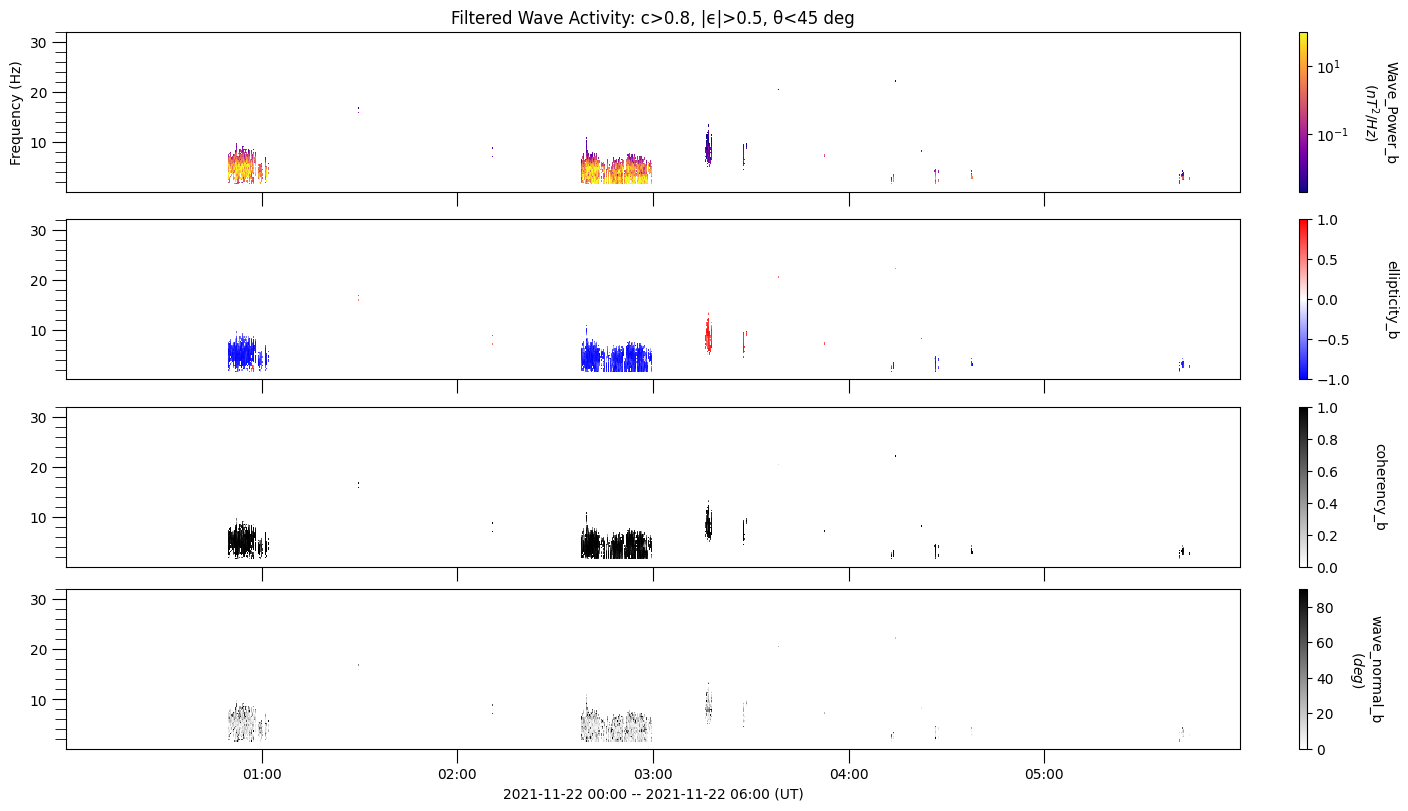

start of time period: 11/22/21 00:00
end of time period: 11/22/21 06:00


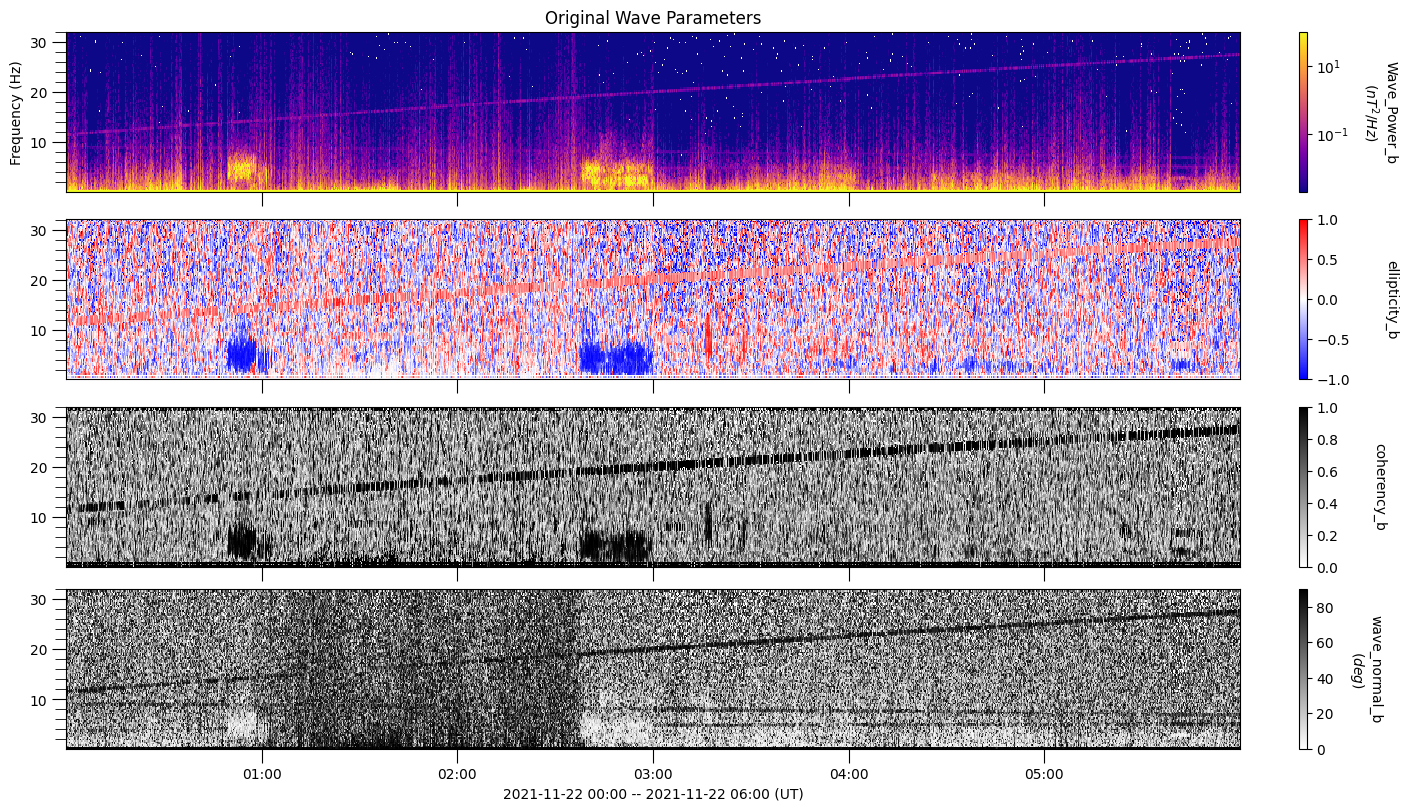

PSP_WaveAnalysis_2021-11-22_0600_v1.3.cdf
Unable to find file for 2021-11-22_0600, version v1.3


In [15]:
# Test if process works:
test_start = tz_check(datetime(2021,11,22,0))
test_end = tz_check(datetime(2021,11,22,6))
fileDirectory = 'Data/' # where I store my waveAnalysis files

extract_activity(test_start,test_end,fileDirectory=fileDirectory,outputDirectory='./',
                 plot_show=True,version='1.3',fileLog=False,skip_existing=False,verbose=True)

In [ ]:
plt.close('all')

# the following start and end dates are what was used to generate the filteredActivity files:

# enc08_start = tz_check(datetime(2021,4,24,0,0)) # enc08
# enc08_end = tz_check(datetime(2021,5,4,19,00))
enc09_start = tz_check(datetime(2021,8,4,0,0)) # enc09
enc09_end = tz_check(datetime(2021,8,15,19,00))
# enc10_start = tz_check(datetime(2021,11,16,0,0)) # enc10
# enc10_end = tz_check(datetime(2021,11,26,23,59))
# enc10_start = tz_check(datetime(2021,11,22,0,0)) # enc10 test
# enc10_end = tz_check(datetime(2021,11,23,19,0))
# enc11_start = tz_check(datetime(2022,2,20,0,0)) #enc11
# enc11_end = tz_check(datetime(2022,3,2,19,0))
# enc13_start = tz_check(datetime(2022,9,1,0,0)) #enc13
# enc13_end = tz_check(datetime(2022,9,11,19,0))
# enc14_start = tz_check(datetime(2022,12,6,0,0)) #enc14
# enc14_end = tz_check(datetime(2022,12,16,19,0))
# enc15_start = tz_check(datetime(2023,3,12,0,0)) #enc15
# enc15_end = tz_check(datetime(2023,3,23,19,0))
# enc16_start = tz_check(datetime(2023,6,16,0,0)) #enc16
# enc16_end = tz_check(datetime(2023,6,27,19,0))

fileDirectory = '' #directory where waveAnalysis files are contained

extract_activity(enc09_start,enc09_end,fileDirectory=fileDirectory,outputDirectory='./Data/',
                 plot_save=True,version='1.3',fileLog=True,skip_existing=True)

Below is the result of filtering on waveAnalysis file for 2021-11-22_0000. Above is the original data and below is after filtering with coherency $C > 0.8$, ellipticity $|\epsilon|>0.5$ and wave normal angle $ \theta_{kB}< 45^\circ$

![title](originalParameters_2021-11-22_0000__2021-11-22_0600.png)
![title](filteredParameters_2021-11-22_0000__2021-11-22_0600.png)

In [ ]:
# encounters as defined by PSP within 0.25 AU of Sun
encounters = {
    8:{'start':tz_check(datetime(2021,4,24,0,9,36)),'end':tz_check(datetime(2021,5,4,17,24,7))}, #enc 08
    9:{'start':tz_check(datetime(2021,8,4,10,33,13)),'end':tz_check(datetime(2021,8,15,3,47,42))}, #enc 09
    10:{'start':tz_check(datetime(2021,11,16,4,18,4)),'end':tz_check(datetime(2021,11,26,12,30,33))}, #enc 10
    11:{'start':tz_check(datetime(2022,2,20,11,32,56)),'end':tz_check(datetime(2022,3,2,19,45,25))}, #enc 11
    12:{"start":tz_check(datetime(2022,5,27,18,46,13)),'end':tz_check(datetime(2022,6,7,2,58,48))}, #enc 12
    13:{"start":tz_check(datetime(2022,9,1,1,58,56)),'end':tz_check(datetime(2022,9,11,10,11,31))}, #enc 13
    14:{"start":tz_check(datetime(2022,12,6,9,10,33)),'end':tz_check(datetime(2022,12,16,23,40,31))}, #enc 14
    15:{"start":tz_check(datetime(2023,3,12,16,25,5)),'end':tz_check(datetime(2023,3,23,0,38,14))}, #enc 15
    16:{"start":tz_check(datetime(2023,6,16,23,40,31)),'end':tz_check(datetime(2023,6,27,7,53,49))}   #enc 16
}

# The filtering algorithm produces files in 6 hour chucks matching Kristoff's convention. 
# To combine them all files for a given encounter into one file, we need the following procedure
# read in filteredActivity files and sort into encounters
enc_files = np.sort(glob.glob('Data/filteredActivity_*.txt'))

enc_sorted_files = {i+8: enc_files[[encounters[i+8]['start'].replace(second=0, minute=0,hour=0) <= tz_check(datetime(*[int(item) for item in date.split('_')[1].split('-')])) <= encounters[i+8]['end'].replace(second=0, minute=0,hour=0)+timedelta(days=1) for date in enc_files]] for i in range(len(encounters))}

for enc in range(8,16+1):
    if enc < 10:
        enc_str = '0' + str(enc)
    else:
        enc_str = str(enc)
    with open(f'enc{enc_str}_filteredActivity.txt','wb') as wfd:
        for f in enc__sorted_files[enc]:
            with open(f,'rb') as fd:
                shutil.copyfileobj(fd, wfd)


# Reading in filteredActivity files

In [16]:
# the 9 column names of the filteredActivty files which are csv
colnames =['cdf epoch','lh integrated wave power (nT^2)','rh integrated wave power(nT^2)','lh med ellipticity','rh med ellipticity','lh med coherency','rh med coherency','lh med wave normal angle','rh med wave normal angle']
# pandas read_csv function handles the files swiftly
test_file = pd.read_csv(f'enc08_filteredActivity.txt',delimiter=',',names=colnames)
# the first column corresponds to time and needs to be converted into a more usable format like datetime.
date_list = cdflib.cdfepoch.breakdown_epoch(test_file['cdf epoch'].to_numpy()) # extract time data and convert to datetime dtype.